# Analisis Sentiment Calon Presiden Indonesia 2019 dengan Metode Support Vector Machines dan Long-Short Term Memory Pada Media Sosial Twitter

Andika Pratama & Panji Christoper Silalahi  

## LIBRARY


In [ ]:
!pip install nlp-id

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.8/54.8 MB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.5/320.5 kB 10.2 MB/s eta 0:00:00
  Created wheel for nlp-id: filename=nlp_id-0.1.15.0-py3-none-any.whl size=58153892 sha256=00cb0462868a569b10027fe5ce51a9a086a8f2c82f11a5de8606a88a1cff56c1
  Stored in directory: /root/.cache/pip/wheels/85/34/2a/deaf7b7896a1eed336b874e1a7732588d40bb7bdc0a824e73e
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=8cb902d8ace2b839b8368400e9caf60b9874d63cda67a63ce956987fac8da63d
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built nlp-id wget
  Attempting uninstall: pytest
    Found existing installation: pytest 7.4.4
    Uninstalling pytest-7.4.4:
      Successfully uninstalled pytest-7.4.4


In [ ]:
!pip install tensorflow keras

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import json
import nltk

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

from wordcloud import WordCloud

from gensim.models import Word2Vec
from gensim.models.word2vec import LineSentence

from nlp_id.lemmatizer import Lemmatizer
# from nlp_id.tokenizer import Tokenizer
# from nlp_id.tokenizer import PhraseTokenizer
# from nlp_id.postag import PosTag
from nlp_id.stopword import StopWord

# from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Bidirectional
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras.callbacks import Callback

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, roc_auc_score

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## DATASET

In [ ]:
import pandas as pd
df = pd.read_excel('/content/sample_data/tweet1.xlsx')
df.head()

,no,sentimen,tweet
0,0,0,Kata @prabowo Indonesia tidak dihargai bangsa ...
1,1,1,"Batuan Langka, Tasbih Jokowi Hadiah dari Habib..."
2,2,1,"Di era Jokowi, ekonomi Indonesia semakin baik...."
3,3,1,"Bagi Sumatera Selatan, Asian Games berdampak p..."
4,4,0,Negara kita ngutang buat bngun infrastruktur y...


In [ ]:
df.tail()


,no,sentimen,tweet
1810,1810,1,Negarawan sejati sll bangga dan mengedepankan ...
1811,1811,1,1. HRS ceramah di Damai Indonesiaku 2. Perekon...
1812,1812,1,Mari bangun bangsa dgn mendukung perekonomian ...
1813,1813,1,Bantu majukan perekonomian bangsa bersama Pak ...
1814,1814,1,Pak @jokowi mengubah cara pandang ekonomi. Kin...


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1815 entries, 0 to 1814
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   no        1815 non-null   int64 
 1   sentimen  1815 non-null   int64 
 2   tweet     1815 non-null   object
dtypes: int64(2), object(1)
memory usage: 42.7+ KB


## PROCESSING DATA



In [ ]:
#Text sebelum diproses
print(df.head())

   no  sentimen                                              tweet
0   0         0  Kata @prabowo Indonesia tidak dihargai bangsa ...
1   1         1  Batuan Langka, Tasbih Jokowi Hadiah dari Habib...
2   2         1  Di era Jokowi, ekonomi Indonesia semakin baik....
3   3         1  Bagi Sumatera Selatan, Asian Games berdampak p...
4   4         0  Negara kita ngutang buat bngun infrastruktur y...


In [ ]:
print(df.groupby('sentimen').describe())

              no                                                            
           count        mean         std  min    25%    50%      75%     max
sentimen                                                                    
0          596.0  925.731544  508.037094  0.0  511.5  953.0  1361.25  1805.0
1         1219.0  897.841674  531.726988  1.0  427.5  894.0  1359.00  1814.0


In [ ]:
#Menghapus data duplikat
df = df.drop_duplicates()

In [ ]:
# Menyeimbangkan jumlah positif dan negatif sentiment
df_neg = df[df['sentimen'] == 0]
df_pos = df[df['sentimen'] == 1].head(596)
df = pd.concat([df_pos, df_neg], axis=0)
df.groupby('sentimen').describe()

no                                                            
          count        mean         std  min    25%    50%      75%     max
sentimen                                                                   
0         596.0  925.731544  508.037094  0.0  511.5  953.0  1361.25  1805.0
1         596.0  426.879195  251.300989  1.0  218.5  415.5   646.25   875.0

In [ ]:
print(df.groupby('sentimen').describe())

             no                                                            
          count        mean         std  min    25%    50%      75%     max
sentimen                                                                   
0         596.0  925.731544  508.037094  0.0  511.5  953.0  1361.25  1805.0
1         596.0  426.879195  251.300989  1.0  218.5  415.5   646.25   875.0


In [ ]:
#set stop word
nltk.download('stopwords')
stop_words = stopwords.words('indonesian')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
def preprocess_text(review):
    review = re.sub(r"http\S+", "", review)             # menghapus link website
    review = re.sub("\S*\d\S*", "", review).strip()     # proses menghapus nomor
    review = re.sub('[^A-Za-z]+', ' ', review)          # proses menghapus selain huruf
    review = review.translate(str.maketrans("","",string.punctuation)) #menghapus tanda baca
    review = review.lower()                             # proses case folding
    review = [word for word in review.split(" ") if not word in stop_words] # proses stop word
    review = " ".join(review)
    review.strip()
    return review

df['tweet_clean'] = df['tweet'].apply(lambda x: preprocess_text(x))

In [ ]:
# Text setelah diproses
df.head(150)

,no,sentimen,tweet,tweet_clean
1,1,1,"Batuan Langka, Tasbih Jokowi Hadiah dari Habib...",batuan langka tasbih jokowi hadiah habib luthf...
2,2,1,"Di era Jokowi, ekonomi Indonesia semakin baik....",era jokowi ekonomi indonesia jokowilagi jokowi...
3,3,1,"Bagi Sumatera Selatan, Asian Games berdampak p...",sumatera selatan asian games berdampak pd ekon...
5,5,1,"Yg bisikin pak jokowi, cm mikirin perputaran d...",yg bisikin jokowi cm mikirin perputaran duit g...
6,6,1,Masa tenang msih ngoceh aja..ttp jokowi harga ...,tenang msih ngoceh aja ttp jokowi harga mati
...,...,...,...,...
213,213,1,"Maaf mas saya gk pake yg subsidi,saya pake yg1...",maaf mas gk pake yg subsidi pake harga udah te...
214,214,1,"Video dengan sudut pandang berbeda, mau @jokow...",video sudut pandang berbeda jokowi prabowo vid...
216,216,1,Saya selalu berdoa dalam hati.agar pak @prabow...,berdoa hati prabowo mjd presiden ri ekonomi bu...
217,217,1,Presiden Jokowi - Raja Salman Sepakat Tingkatk...,presiden jokowi raja salman sepakat tingkatkan...


In [ ]:
# Menentukan Fitur dan Target
X = df['tweet_clean'].tolist()
Y = to_categorical(df['sentimen'])
print("Shape pada sentiment:",Y.shape)

Shape pada sentiment: (1192, 2)


In [ ]:
#tokenizing
max_features = 2500
MAX_SEQUENCE_LENGTH = 50

tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(X)

word_index = tokenizer.word_index
print("Found %s unique tokens" % len(word_index),'\n')
print("Index: "+str(tokenizer.word_index),"\n")

X = tokenizer.texts_to_sequences(X)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating="post")

Found 5285 unique tokens 

Index: {'jokowi': 1, 'ekonomi': 2, 'prabowo': 3, 'yg': 4, 'gaji': 5, 'presiden': 6, 'harga': 7, 'sandi': 8, 'indonesia': 9, 'rakyat': 10, 'gak': 11, 'ga': 12, 'ya': 13, 'aja': 14, 'salah': 15, 'negara': 16, 'ambil': 17, 'kerja': 18, 'nya': 19, 'kalo': 20, 'pertumbuhan': 21, 'makro': 22, 'pilihorangbaik': 23, 'pajak': 24, 'sandiuno': 25, 'tdk': 26, 'pilihjelasislamnya': 27, 'orang': 28, 'pilihbajuputih': 29, 'game': 30, 'tp': 31, 'debat': 32, 'bilang': 33, 'janji': 34, 'pemimpin': 35, 'dgn': 36, 'anak': 37, 'perekonomian': 38, 'murah': 39, 'sby': 40, 'utk': 41, 'terpilih': 42, 'gajinya': 43, 'bangsa': 44, 'mahal': 45, 'udah': 46, 'prabowosalahkansby': 47, 'arah': 48, 'mobile': 49, 'legend': 50, 'pilih': 51, 'mikro': 52, 'wowo': 53, 'dr': 54, 'jd': 55, 'lu': 56, 'era': 57, 'pembangunan': 58, 'uang': 59, 'kesalahan': 60, 'sih': 61, 'tau': 62, 'krn': 63, 'uasdifitnahkejidanbrutal': 64, 'jg': 65, 'miskin': 66, 'sembako': 67, 'mati': 68, 'bayar': 69, 'bang': 70, 's

In [ ]:
from nltk.data import find
from gensim.models import KeyedVectors

# Download the word2vec sample model from nltk
nltk.download('word2vec_sample')

# Get the path to the model file
model_path = find('models/word2vec_sample/pruned.word2vec.txt')

# Load the word2vec model
model = KeyedVectors.load_word2vec_format(model_path, binary=False)

[nltk_data] Downloading package word2vec_sample to /root/nltk_data...
[nltk_data]   Unzipping models/word2vec_sample.zip.


In [ ]:
model_weights = model.vectors

In [ ]:
vocab_size, embedding_size = model_weights.shape
print("Size Kamus: {} - Dimensi Embedding: {}".format(vocab_size, embedding_size))

Size Kamus: 43981 - Dimensi Embedding: 300


## WORDCLOUNDS

In [ ]:
df['tweet_clean'] = df['tweet'].apply(preprocess_text)

In [ ]:
df.head(5)

,no,sentimen,tweet,tweet_clean
1,1,1,"Batuan Langka, Tasbih Jokowi Hadiah dari Habib...",batuan langka tasbih jokowi hadiah habib luthf...
2,2,1,"Di era Jokowi, ekonomi Indonesia semakin baik....",era jokowi ekonomi indonesia jokowilagi jokowi...
3,3,1,"Bagi Sumatera Selatan, Asian Games berdampak p...",sumatera selatan asian games berdampak pd ekon...
5,5,1,"Yg bisikin pak jokowi, cm mikirin perputaran d...",yg bisikin jokowi cm mikirin perputaran duit g...
6,6,1,Masa tenang msih ngoceh aja..ttp jokowi harga ...,tenang msih ngoceh aja ttp jokowi harga mati


Text(0, 0.5, 'Text Length')

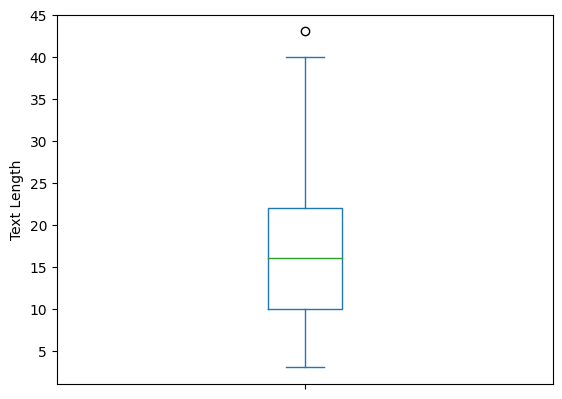

In [ ]:
text_length = pd.Series([len(review.split()) for review in df["tweet_clean"]])
text_length.plot(kind="box")
plt.ylabel("Text Length")

<ipython-input-26-fe0843c0c1ff>:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(text_length,palette="deep")


Text(0, 0.5, 'Frequency')

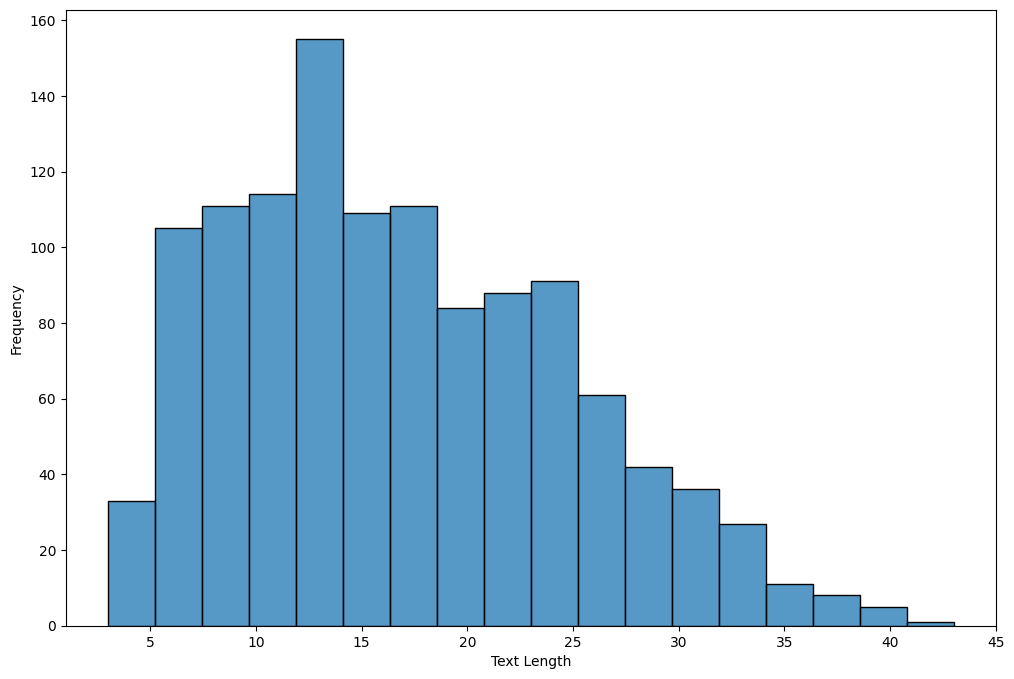

In [ ]:
plt.figure(figsize=(12,8))
sns.histplot(text_length,palette="deep")
plt.xlabel("Text Length")
plt.ylabel("Frequency")

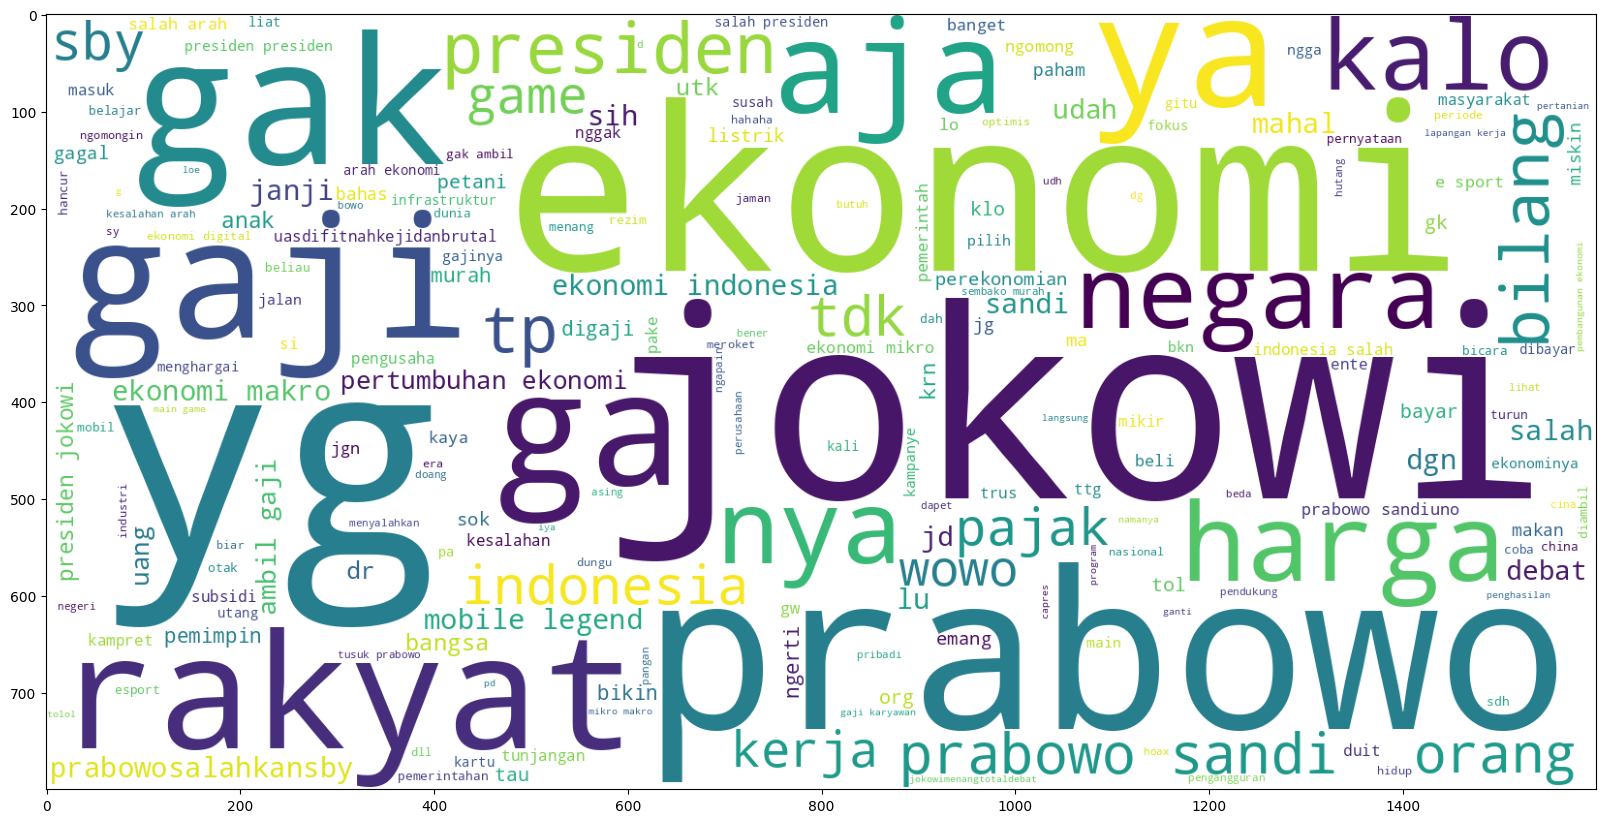

In [ ]:
# Negative Review WordCloud
plt.figure(figsize=(20,20))
wc1 = WordCloud(max_words=2000,min_font_size=10, height=800, width=1600,
               background_color="white").generate(" ".join(df[df["sentimen"]==0].tweet_clean))
plt.imshow(wc1)

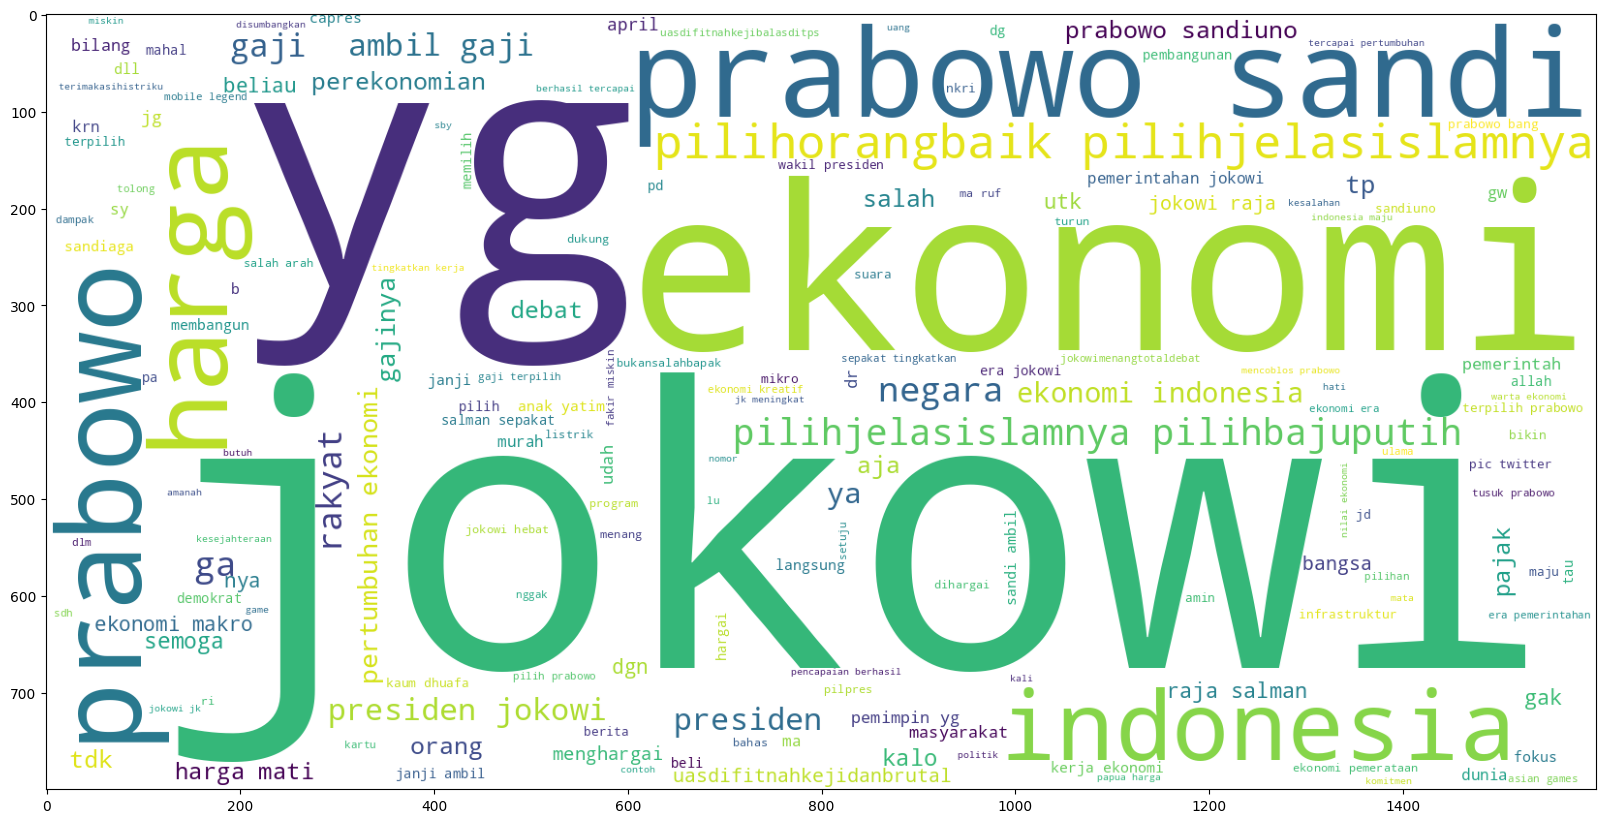

In [ ]:
# Positive Review WordCloud
plt.figure(figsize=(20,20))
wc1 = WordCloud(max_words=2000,min_font_size=10, height=800, width=1600,
               background_color="white").generate(" ".join(df[df["sentimen"]==1].tweet_clean))
plt.imshow(wc1)

## DATA SPLIT


In [ ]:
# Split Dataset
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 0, stratify = Y)
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(953, 50) (953, 2)
(239, 50) (239, 2)


## DEEP LEARNING


In [ ]:
from sklearn.model_selection import train_test_split
X = df["tweet_clean"]
y = df.sentimen
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
display(X_train.shape)
display(X_test.shape)

(894,)

(298,)

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [ ]:
# using tokenizer to transform text messages into training and testing set
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

In [ ]:
X_train_seq_padded = pad_sequences(X_train_seq, maxlen=64)
X_test_seq_padded = pad_sequences(X_test_seq, maxlen=64)

In [ ]:
X_train_seq_padded[0]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  24,
        30,  32,  65,   1, 266,   2,   9, 432,  35,  35, 267,  97],
      dtype=int32)

## BI-LTSM

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 64)          283008    
                                                                 
 bidirectional (Bidirection  (None, 200)               132000    
 al)                                                             
                                                                 
 dense (Dense)               (None, 128)               25728     
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 440865 (1.68 MB)
Trainable params: 440865 (1.68 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


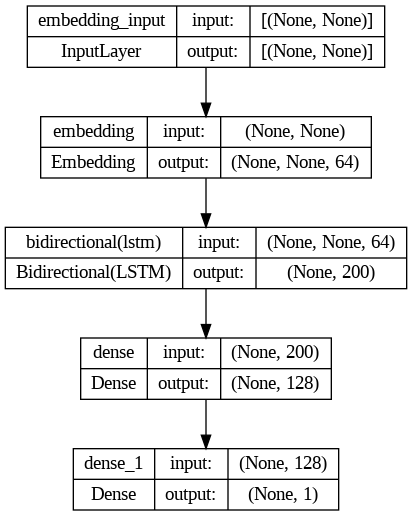

In [ ]:
# construct model
BATCH_SIZE = 64

from tensorflow.keras.utils import plot_model  # Import from tensorflow.keras
model = Sequential()
model.add(Embedding(len(tokenizer.index_word)+1, 64))
model.add(Bidirectional(LSTM(100, dropout=0, recurrent_dropout=0)))
model.add(Dense(128, activation="relu"))
model.add(Dense(1, activation="sigmoid"))

model.compile("adam", "binary_crossentropy", metrics=["accuracy"])
model.summary()
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
# Used for preventing ovefitting
from keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor="val_loss",patience=5,verbose=True)

In [ ]:
history = model.fit(X_train_seq_padded, y_train,batch_size=BATCH_SIZE,epochs=15,
                    validation_data=(X_test_seq_padded, y_test))

Epoch 1/15
14/14 [==============================] - 10s 307ms/step - loss: 0.6898 - accuracy: 0.5380 - val_loss: 0.6883 - val_accuracy: 0.5134
Epoch 2/15
14/14 [==============================] - 4s 290ms/step - loss: 0.6333 - accuracy: 0.6644 - val_loss: 0.6396 - val_accuracy: 0.6409
Epoch 3/15
14/14 [==============================] - 5s 369ms/step - loss: 0.4103 - accuracy: 0.8345 - val_loss: 0.5724 - val_accuracy: 0.7215
Epoch 4/15
14/14 [==============================] - 5s 369ms/step - loss: 0.2900 - accuracy: 0.9150 - val_loss: 0.6585 - val_accuracy: 0.7148
Epoch 5/15
14/14 [==============================] - 3s 251ms/step - loss: 0.2055 - accuracy: 0.9217 - val_loss: 0.6597 - val_accuracy: 0.7013
Epoch 6/15
14/14 [==============================] - 6s 391ms/step - loss: 0.0930 - accuracy: 0.9810 - val_loss: 0.7043 - val_accuracy: 0.6879
Epoch 7/15
14/14 [==============================] - 5s 359ms/step - loss: 0.0424 - accuracy: 0.9944 - val_loss: 0.7763 - val_accuracy: 0.6913
Epoch

In [ ]:
from sklearn.metrics import roc_auc_score
pred_train = model.predict(X_train_seq_padded)
pred_test = model.predict(X_test_seq_padded)
print('LSTM Recurrent Neural Network baseline: ' + str(roc_auc_score(y_train, pred_train)))
print('LSTM Recurrent Neural Network: ' + str(roc_auc_score(y_test, pred_test)))

10/10 [==============================] - 0s 28ms/step
LSTM Recurrent Neural Network baseline: 1.0
LSTM Recurrent Neural Network: 0.7738963963963963


In [ ]:
model.evaluate(X_test_seq_padded, y_test)

10/10 [==============================] - 0s 27ms/step - loss: 1.1573 - accuracy: 0.7148


[1.1573052406311035, 0.7147650718688965]

Text(0.5, 1.0, 'Training and Validation Accuracy')

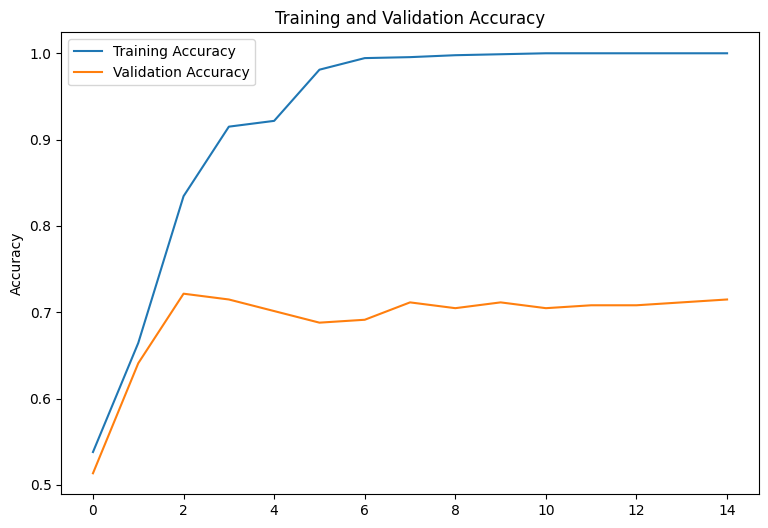

In [ ]:
acc = history.history["accuracy"]
loss = history.history["loss"]

val_acc = history.history["val_accuracy"]
val_loss = history.history["val_loss"]

plt.figure(figsize=(9,6))
plt.plot(acc,label="Training Accuracy")
plt.plot(val_acc,label="Validation Accuracy")
plt.legend()
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")

Text(0.5, 1.0, 'Training and Validation Loss')

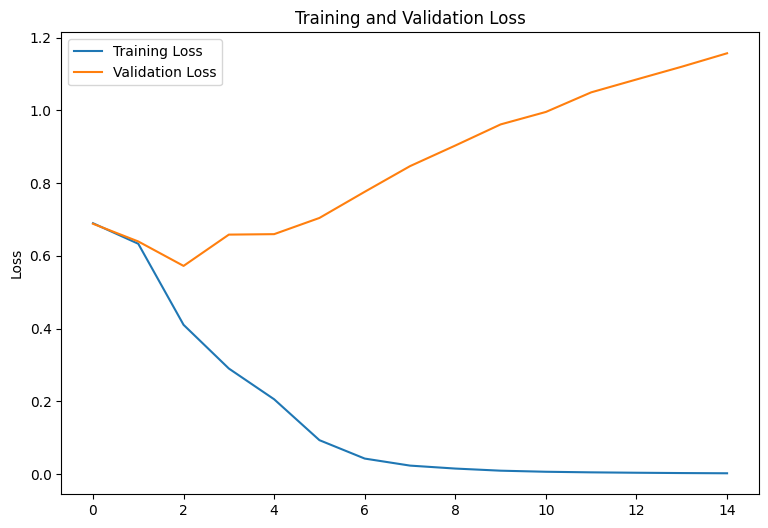

In [ ]:
plt.figure(figsize=(9,6))
plt.plot(loss,label="Training Loss")
plt.plot(val_loss, label="Validation Loss")
plt.legend()
plt.ylabel("Loss")
plt.title("Training and Validation Loss")

In [ ]:
from sklearn.metrics import classification_report

# Prediksi kelas dari data uji
y_pred = model.predict(X_test_seq_padded)
y_pred = (y_pred > 0.5).astype(int)  # Ubah probabilitas menjadi kelas biner (0 atau 1)

# Buat laporan klasifikasi
report = classification_report(y_test, y_pred, target_names=['class negatif', 'class positif'])

# Print laporan klasifikasi
print("Classification Report:")
print(report)


10/10 [==============================] - 0s 29ms/step
Classification Report:
               precision    recall  f1-score   support

class negatif       0.70      0.75      0.72       148
class positif       0.73      0.68      0.71       150

     accuracy                           0.71       298
    macro avg       0.72      0.72      0.71       298
 weighted avg       0.72      0.71      0.71       298



In [ ]:
from sklearn.metrics import precision_score

# Prediksi kelas dari data uji
y_pred = model.predict(X_test_seq_padded)
y_pred_binary = (y_pred > 0.5).astype(int)  # Ubah probabilitas menjadi kelas biner (0 atau 1)

# Hitung nilai precision
precision = precision_score(y_test, y_pred_binary)

# Cetak nilai precision
print("Precision:", precision)


10/10 [==============================] - 0s 31ms/step
Precision: 0.7338129496402878


In [ ]:
# Prediksi kelas dari data uji
y_pred = model.predict(X_test_seq_padded)
y_pred_binary = (y_pred > 0.5).astype(int)  # Ubah probabilitas menjadi kelas biner (0 atau 1)

# Hitung nilai recall
recall = recall_score(y_test, y_pred_binary)

# Cetak nilai recall
print("Recall:", recall)


10/10 [==============================] - 1s 83ms/step
Recall: 0.68


In [ ]:
# Prediksi kelas dari data uji
y_pred = model.predict(X_test_seq_padded)
y_pred_binary = (y_pred > 0.5).astype(int)  # Ubah probabilitas menjadi kelas biner (0 atau 1)

# Hitung nilai F1-score
f1 = f1_score(y_test, y_pred_binary)

# Cetak nilai F1-score
print("F1-score:", f1)


10/10 [==============================] - 0s 27ms/step
F1-score: 0.7058823529411765


In [ ]:
# Prediksi kelas dari data uji
y_pred = model.predict(X_test_seq_padded)
y_pred_binary = (y_pred > 0.5).astype(int)  # Ubah probabilitas menjadi kelas biner (0 atau 1)

# Hitung nilai akurasi
accuracy = accuracy_score(y_test, y_pred_binary)

# Cetak nilai akurasi
print("Accuracy:", accuracy)


10/10 [==============================] - 1s 85ms/step
Accuracy: 0.714765100671141


In [ ]:
# Prediksi probabilitas dari data uji
y_pred = model.predict(X_test_seq_padded)

# Hitung nilai ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred)

# Cetak nilai ROC AUC score
print("ROC AUC Score:", roc_auc)


10/10 [==============================] - 0s 45ms/step
ROC AUC Score: 0.7738963963963963


10/10 [==============================] - 0s 47ms/step


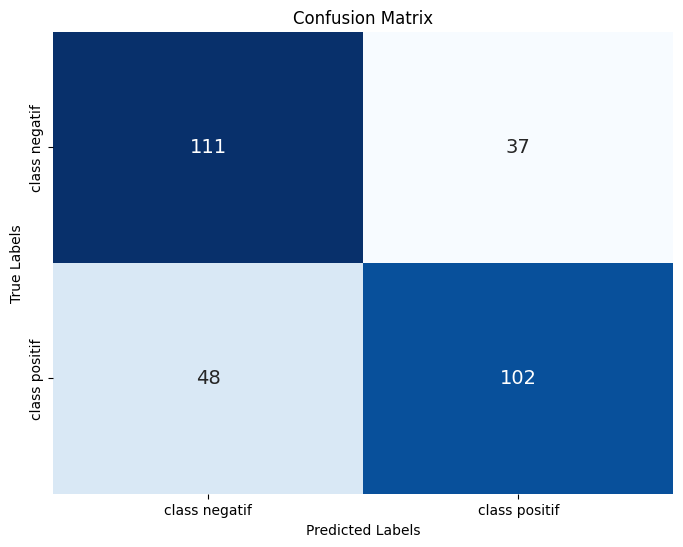

In [ ]:
# Prediksi kelas dari data uji
y_pred = model.predict(X_test_seq_padded)
y_pred_binary = (y_pred > 0.5).astype(int)  # Ubah probabilitas menjadi kelas biner (0 atau 1)

# Hitung Confusion Matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            annot_kws={'size': 14},
            xticklabels=['class negatif', 'class positif'],
            yticklabels=['class negatif', 'class positif'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

## SVM


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(ngram_range=(1, 2), stop_words=stop_words, min_df=20)
x = vectorizer.fit_transform(df['tweet_clean'])
y = df['sentimen']

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['baiknya', 'berkali', 'kali', 'kurangnya', 'mata', 'olah', 'sekurang', 'setidak', 'tama', 'tidaknya'] not in stop_words.
  warnings.warn(


In [ ]:
text = vectorizer.transform(['prabowo jelek banget kayak badud'])
text = vectorizer.inverse_transform(text)
print(text)

[array(['prabowo'], dtype='<U33')]


In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=0)

In [ ]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=1000, random_state=0)
model.fit(x_train, y_train)

LogisticRegression(max_iter=1000, random_state=0)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score
y_pred=model.predict(x_test)
cm=confusion_matrix(y_test,y_pred)
cm

#printing accuracy,Confusion matrix,Precision and Recall
print('\nAccuracy of the classifier is',metrics.accuracy_score(y_test,y_pred))
print('\nConfusion matrix is:\n',metrics.confusion_matrix(y_test,y_pred))
print('\nclassification report is:\n',metrics.classification_report(y_test,y_pred))
print('\nThe value of Precision',metrics.precision_score(y_test,y_pred))
print('\nThe value of Recall',metrics.recall_score(y_test,y_pred))



Accuracy of the classifier is 0.575

Confusion matrix is:
 [[38 25]
 [26 31]]

classification report is:
               precision    recall  f1-score   support

           0       0.59      0.60      0.60        63
           1       0.55      0.54      0.55        57

    accuracy                           0.57       120
   macro avg       0.57      0.57      0.57       120
weighted avg       0.57      0.57      0.57       120


The value of Precision 0.5535714285714286

The value of Recall 0.543859649122807


Text(95.72222222222221, 0.5, 'Truth')

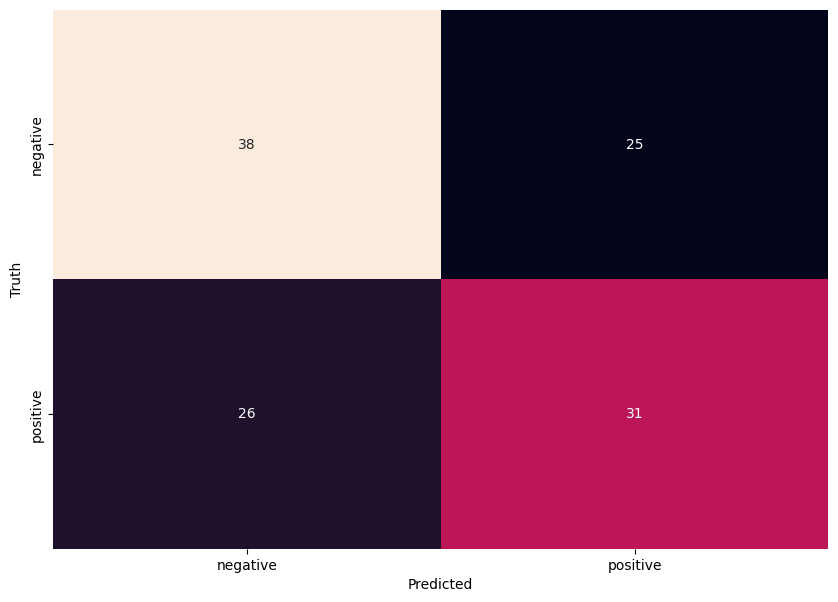

In [ ]:
plt.figure(figsize=(10,7))
labels = ['negative','positive']
sns.heatmap(cm, annot=True, fmt='d', cbar=False, xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("Truth")

In [ ]:
accuracy = accuracy_score(y_test, y_pred)*100
accuracy

57.49999999999999

In [ ]:
model.score(x_test, y_test)

0.575

In [ ]:
from sklearn.metrics import roc_auc_score

probabilities = model.predict_proba(x_test)
roc_auc_score(y_test, probabilities[:, 1])

0.6516290726817042

In [ ]:
from sklearn import svm
#The 'kernel' parameter of SVC must be a str among {'linear', 'precomputed', 'sigmoid', 'poly', 'rbf'}
clf = svm.SVC(kernel='linear', gamma='auto')
clf.fit(x_train, y_train)

SVC(gamma='auto', kernel='linear')

In [ ]:
ypredict = clf.predict(x_test)
ypredict [0:5]

array([1, 0, 1, 0, 0])

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
#printing accuracy,Confusion matrix,Precision and Recall
print("Train set Accuracy: ", metrics.accuracy_score(y_train, clf.predict(x_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, ypredict))

print('\nAccuracy of the classifier is',metrics.accuracy_score(y_test,ypredict))
print('\nConfusion matrix is:\n',metrics.confusion_matrix(y_test,ypredict))
print('\nclassification report is:\n',metrics.classification_report(y_test,ypredict))
print('\nThe value of Precision',metrics.precision_score(y_test,ypredict))
print('\nThe value of Recall',metrics.recall_score(y_test,ypredict))

Train set Accuracy:  0.7779850746268657
Test set Accuracy:  0.5916666666666667

Accuracy of the classifier is 0.5916666666666667

Confusion matrix is:
 [[38 25]
 [24 33]]

classification report is:
               precision    recall  f1-score   support

           0       0.61      0.60      0.61        63
           1       0.57      0.58      0.57        57

    accuracy                           0.59       120
   macro avg       0.59      0.59      0.59       120
weighted avg       0.59      0.59      0.59       120


The value of Precision 0.5689655172413793

The value of Recall 0.5789473684210527


Text(95.72222222222221, 0.5, 'Truth')

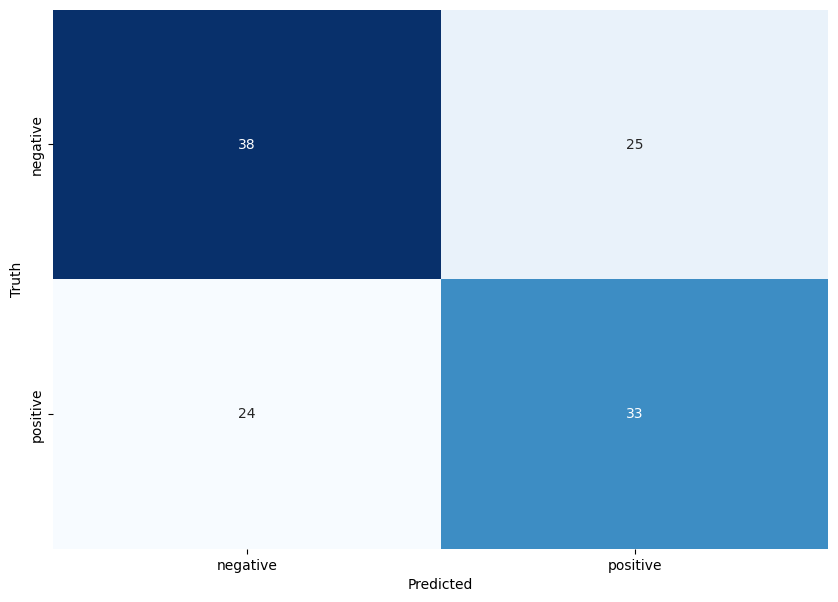

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score
cm=confusion_matrix(y_test,ypredict)
cm
plt.figure(figsize=(10,7))
labels = ['negative','positive']
sns.heatmap(cm, cmap="Blues", annot=True, fmt='d', cbar=False, xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("Truth")

In [ ]:
from sklearn import svm
from sklearn.metrics import classification_report, confusion_matrix
#The 'kernel' parameter of SVC must be a str among {'linear', 'precomputed', 'sigmoid', 'poly', 'rbf'}
clf = svm.SVC(kernel='linear', gamma='auto')
clf.fit(x_train, y_train)
ypredict = clf.predict(x_test)

#printing accuracy,Confusion matrix,Precision and Recall
print("Train set Accuracy: ", metrics.accuracy_score(y_train, clf.predict(x_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, ypredict))

print('\nAccuracy of the classifier is',metrics.accuracy_score(y_test,ypredict))
print('\nConfusion matrix is:\n',metrics.confusion_matrix(y_test,ypredict))
print('\nclassification report is:\n',metrics.classification_report(y_test,ypredict))
print('\nThe value of Precision',metrics.precision_score(y_test,ypredict))
print('\nThe value of Recall',metrics.recall_score(y_test,ypredict))

Train set Accuracy:  0.7779850746268657
Test set Accuracy:  0.5916666666666667

Accuracy of the classifier is 0.5916666666666667

Confusion matrix is:
 [[38 25]
 [24 33]]

classification report is:
               precision    recall  f1-score   support

           0       0.61      0.60      0.61        63
           1       0.57      0.58      0.57        57

    accuracy                           0.59       120
   macro avg       0.59      0.59      0.59       120
weighted avg       0.59      0.59      0.59       120


The value of Precision 0.5689655172413793

The value of Recall 0.5789473684210527


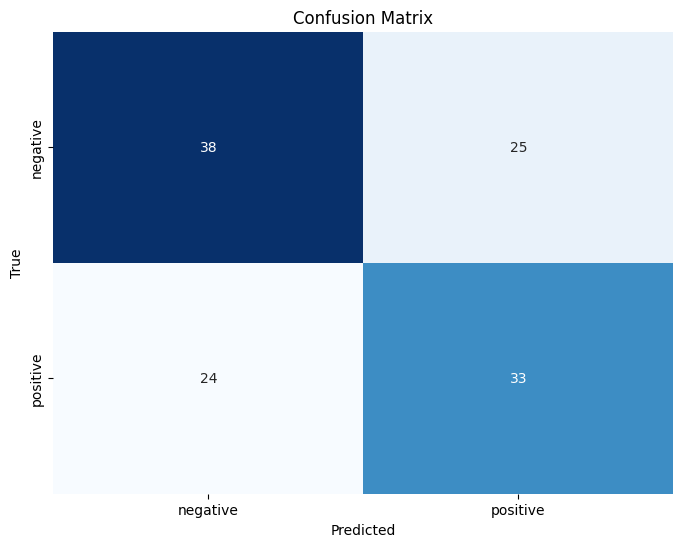

In [ ]:
# Membuat model SVM dengan kernel linear
clf = svm.SVC(kernel='linear', gamma='auto')

# Melatih model menggunakan data latih
clf.fit(x_train, y_train)

# Melakukan prediksi pada data uji
ypredict = clf.predict(x_test)

# Menghitung matriks konfusi
cm = confusion_matrix(y_test, ypredict)

# Plotting Confusion Matrix menggunakan seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', cbar=False,
            xticklabels=['negative', 'positive'],
            yticklabels=['negative', 'positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()